In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from utils import *

# Number of classes
nn = 3

X = load_iris().data
y = load_iris()['target']

# Data preprocessing using standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Initialize the lists to hold the split data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, train_size=90, random_state=101)

# Splitting the data
for i in range(nn):
    # Filter the data for the current class
    X_class = X_tsne[y == i]
    y_class = y[y == i]
    
    # Perform the split (ensure each class is split 50-50)
    X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
        X_class, y_class, test_size=0.8, random_state=101
    )
    
    # Append the current class's split to the lists
    X_train_list.append(X_class_train)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class_train)
    y_test_list.append(y_class_test)

# Concatenate all class splits together
X_train = np.concatenate(X_train_list)
X_test = np.concatenate(X_test_list)
y_train = np.concatenate(y_train_list)
y_test = np.concatenate(y_test_list)

print(f'Dataset split summary:')
print(f'Training set size: {X_train.shape[0]}')
print(f'Testing set size: {X_test.shape[0]}')

Dataset split summary:
Training set size: 30
Testing set size: 120


In [2]:
gamma = 0.01
C = 1

In [3]:
from sklearn.metrics import classification_report, accuracy_score
from smo_svm import smo_SVM, smo_OneVsAllClassifier

# Train Multiclass SVM
smo_solver = smo_OneVsAllClassifier(
    solver=smo_SVM,
    num_classes=nn,
    c=C,
    kkt_thr=1e-5,
    max_iter=1e5,
    kernel_type='rbf',
    gamma_rbf=gamma
)

smo_solver.fit(X_train, y_train)

# Predict
y_pred = smo_solver.predict(X_test)
yt_pred= smo_solver.predict(X_train)

# Performance analysis
smo_test_accuracy = accuracy_score(y_test, y_pred)*100
smo_train_accuracy = accuracy_score(y_train, yt_pred)*100
print(smo_test_accuracy)
print(smo_train_accuracy)
# print(classification_report(y_test, y_pred))

# plot_figure(smo_solver, X_tsne, y, nn, X_test, X_train, y_test, y_train, filename= "results\iris_SMO")

SVM training using SMO algorithm - START
Training summary: 492 iterations, 16 supprts vectors
SVM training using SMO algorithm - DONE!
SVM training using SMO algorithm - START
Training summary: 946 iterations, 19 supprts vectors
SVM training using SMO algorithm - DONE!
SVM training using SMO algorithm - START
Training summary: 505 iterations, 20 supprts vectors
SVM training using SMO algorithm - DONE!
95.83333333333334
96.66666666666667


In [4]:
from sklearn.metrics import classification_report, accuracy_score
from qsvm import *

params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": 1,
    "kernel": "rbf",
    "optimizer": "SA",
    "vis" : 0
}

# Initialize and train the classifier
sa_OvR = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
sa_OvR.solve(X_train, y_train)

# Predict
sa_predict = sa_OvR.predict(X_test)
sa_t_pred= sa_OvR.predict(X_train)

# Performance analysis
sa_test_accuracy = accuracy_score(y_test, sa_predict)*100
sa_training_accuracy = accuracy_score(y_train, sa_t_pred)*100
print(sa_test_accuracy)
print(sa_training_accuracy)
# print(classification_report(y_test, sa_predict))

# plot_figure(sa_OvR, X_tsne, y, nn, X_test, X_train, y_test, y_train, filename= "results\iris_SA")

Training classifier 0...
solving...
K,N 2 30
self.intercept -1.9965117694384917
Training classifier 1...
solving...
K,N 2 30
self.intercept -0.9379304911786568
Training classifier 2...
solving...
K,N 2 30
self.intercept 0.09215428141300624
95.83333333333334
96.66666666666667


In [9]:
from qsvm import *
from utils import *

# emb = load_embedding("iris")

params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": C,
    "kernel": "rbf",
    "optimizer": "MTQA",
    "qubo_list": None,
    "vis": 1
}

# Initialize and train the classifier
mtqa_OvR = MTQA_OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
_, embedding_list, TotalQubo, Qubo_list = mtqa_OvR.solve(X_train, y_train)

save_embedding(embedding_list, "iris")
save_TotalQubo(TotalQubo, "iris")
save_qubo_list(Qubo_list, "iris")

# Predict
mtqa_predict = mtqa_OvR.predict(X_test)
mtqa_t_pred= mtqa_OvR.predict(X_train)

# Performance analysis
mtqa_test_accuracy = accuracy_score(y_test, mtqa_predict)*100
mtqa_training_accuracy = accuracy_score(y_train, mtqa_t_pred)*100
print(mtqa_test_accuracy)
print(mtqa_training_accuracy)

# plot_figure(mtqa_OvR, X_tsne, y, nn, X_test, X_train, y_test, y_train, filename= "results\MTQA")

self.intercept 4.17851878377666
self.intercept 4.293863991462367
self.intercept -0.5397764856382106
96.66666666666667
96.66666666666667


In [21]:
import numpy as np
from pyqubo import Array, Binary, Placeholder, Constraint, solve_qubo
from itertools import combinations
from sklearn.metrics import accuracy_score
import math
import neal
from dwave.system import DWaveSampler, FixedEmbeddingComposite, EmbeddingComposite
from collections import Counter
from itertools import product
import time 
import dwave_networkx as dnx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from MTQA import *

class OneVsRestClassifier:
    def __init__(self, class_num, classifier, params=None):
        """
        Initialize an ensemble of binary classifiers, one for each class.
        
        Parameters:
        - class_num (int): Number of classes.
        - classifier (class): Classifier class to be instantiated for each class.
        - params (dict, optional): Parameters to pass to each classifier instance.
        """
        
        self.class_num = class_num
        if params is None:
            self.classifiers = [classifier() for _ in range(class_num)]
        else:
            self.classifiers = [classifier(**params) for _ in range(class_num)]

    def solve(self, x, y):
        """
        Train each binary classifier on the dataset.
        
        Parameters:
        - x (array): Feature data.
        - y (array): True labels.
        """
        for i in range(self.class_num):
            print(f"Training classifier {i}...")
            self.classifiers[i].solve(x, self.re_labaling(y, i), i)
        return self

    def re_labaling(self, y, pos_label):
        """
        Relabel the dataset for a binary classification task.
        
        Parameters:
        - y (array): Original labels.
        - pos_label (int): The positive class label for the current binary classifier.
        
        Returns:
        - Array of binary labels where the positive class is 1 and all others are -1.
        """
        return np.where(y == pos_label, 1, -1)

    def argmax_by_E(self, result):
        """
        Determine the class with the highest probability based on energy minimization.
        
        Parameters:
        - results (array): Results from all classifiers.
        
        Returns:
        - Array of predicted class labels.
        """
        for i in range(result.shape[0]):
            for j in range(result.shape[1]):
                if np.sum(result[:, j], axis=0) == -1: #case (1,-1,-1)
                    pass
                elif np.sum(result[:, j], axis=0) == 1: #case (1,1,-1)
                    a = np.array(np.where(result[:, j] == 1))[0][0]
                    b = np.array(np.where(result[:, j] == 1))[0][1]
                    if self.classifiers[a].energy > self.classifiers[b].energy:
                        result[a, j] = -1
                    else:
                        result[b, j] = -1
                elif np.sum(result[:, j], axis=0) == 3: #case (1,1,1)
                    min_e = np.argmin(np.array([self.classifiers[0].energy, self.classifiers[1].energy, self.classifiers[2].energy]))
                    result[0:min_e, j] = -1
                    result[min_e:i, j] = -1
                elif np.sum(result[:, j], axis=0) == -3: #case (-1,-1,-1)
                    min_e = np.argmin(
                        np.array([self.classifiers[0].energy, self.classifiers[1].energy, self.classifiers[2].energy]))
                    result[min_e, j] = 1

        # print("result", result)
        return np.argmax(result, axis=0)

    def predict(self, X):
        result = np.array([model.predict(X) for model in self.classifiers])
        # print("result123", result)
        #print("result type and shape", type(result), result.shape)
        #result type and shape <class 'numpy.ndarray'> (3, 150)
        return self.argmax_by_E(result)

    def evaluate(self, X, y):
        """
        Evaluate the classifier's performance on the given test data.
        
        Parameters:
        - X (array): Feature data.
        - y (array): True labels.
        
        Returns:
        - Accuracy of the classifier as a float.
        """
        pred = self.predict(X)
        print("pred result",pred)
        return accuracy_score(y, pred)
    
import networkx as nx
from minorminer import find_embedding

class qSVM():
    def __init__(self, data, label, B=2, K=2, Xi=1, gamma = 0.1, C=3, kernel="rbf", optimizer="SA", qubo_list = None, embeddings = None, vis = 0):
        """
        :param B:
        :param K:
        :param Xi:
        :param gamma:
        :param C: #still not used now
        :param kernel: default; rbf only rbf for now,
        :param optimizer:SA,QA
        """
        # self.data = data
        # self.label = label
        self.B = B
        self.K = K
        self.N = data.shape[0]
        self.Xi = Xi
        self.gamma = float(gamma)
        self.C = C
        self.kernel = kernel
        self.vis = vis

        self.options = {
            'SA': {},
            "QA": {}
        }

        self.optimizer = optimizer
        self.alpha = Array.create('alpha', shape=self.K * self.N, vartype='BINARY') #number of spins : K*N

        self.alpha_result = None
        self.alpha_result_array = None
        self.alpha_real = np.zeros((self.N,))

        self._support_vectors = None
        self._n_support = None
        self._alphas = None
        self._support_labels = None
        self._indices = None
        self.intercept = None
        self.energy = None
        self.emb = embeddings
        self.qubo_list = qubo_list


    def rbf(self, x, y):
        # return np.exp(-self.gamma*(np.linalg.norm(x-y, ord=2)))
        return np.exp(-1.0 * self.gamma * np.dot(np.subtract(x, y).T, np.subtract(x, y)))

    def transform(self, X):
        K = np.zeros([X.shape[0], X.shape[0]])
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                K[i, j] = self.rbf(X[i], X[j])
        return K

    def makeQUBO(self, data, label):
        x = data
        t = label
        alpha = self.alpha
                
        energy = 0
        for n in range(self.N):
            for m in range(self.N):
                for k in range(self.K):
                    for j in range(self.K):
                        alpha[self.K * n +k] * alpha[self.K * m +j] * t[n] * t[m] * self.rbf(x[n],x[m]) * self.B ** (k+j)

        const_1=0
        for n in range(self.N):
            for k in range(self.K):
                const_1 += alpha[self.K * n +k] * self.B ** k

        const_2=0
        for n in range(self.N):
            for k in range(self.K):
                const_2 += alpha[self.K * n +k] * t[n] * self.B ** k

        const_2= const_2 ** 2

        h = 0.5 * energy - const_1 + self.Xi * const_2

        model = h.compile()
        qubo, offset = model.to_qubo()

        return qubo_conversion(qubo)

    def solve(self, data, label, i=None):
        print("solving...")
        qubo = self.makeQUBO(data, label)

        if self.optimizer == "SA":
            sampleset = neal.SimulatedAnnealingSampler().sample_qubo(qubo, num_reads=4000)
            best_sample = sampleset.first
            
            self.energy = best_sample[1]
            self.alpha_result = list(best_sample[0].values())
            self.alpha_result = np.reshape(self.alpha_result,(self.K * self.N))
        
        elif self.optimizer == "QA":
            # ------- Set up D-Wave parameters -------
            token = 'DEV-b3591d636174d4dcd3584a7ea29829d424e703b3' #happynice1008@gmail.com
            endpoint = 'https://cloud.dwavesys.com/sapi/'
            dw_sampler = DWaveSampler(solver='Advantage_system6.4', token=token, endpoint=endpoint)

            if not self.qubo_list:
                hardware = nx.Graph(dw_sampler.edgelist)
                emb = find_embedding(qubo, hardware, tries=10, max_no_improvement=10, chainlength_patience=10, timeout=10, threads=100)
                sampler = FixedEmbeddingComposite(dw_sampler, embedding=emb)
                best_sample = sampler.sample_qubo(qubo, num_reads=4000, annealing_time = 20, label='QA_SVM').first

            else:
                print(i, len(self.qubo_list[i]))
                response = dw_sampler.sample_qubo(self.qubo_list[i], num_reads = 4, annealing_time = 20, answer_mode = 'raw', auto_scale = False, label='QA_SVM').first
                bqm = dimod.BinaryQuadraticModel.from_qubo(qubo)
                best_sample = unembed_sampleset(response, self.embeddings, bqm, chain_break_method="minimize_energy")
                

            print(best_sample)
            self.energy = best_sample[1]
            self.alpha_result = list(best_sample[0].values())
            self.alpha_result = np.reshape(self.alpha_result,(self.K * self.N))

            if self.vis:
                m=16
                P16 = dnx.pegasus_graph(m)

                clr_dict = {}
                for i, j in emb.items():
                    clr_dict[i] = "Red"
                    
                # Draw the graph
                dnx.draw_pegasus_embedding(P16, emb, crosses=False, chain_color = clr_dict, unused_color = "#CCCCCC", width=0.3, node_size = 0.5)
                
                plt.show()
            
        else:
            print("This optimizer is not available")

        K = self.transform(data)

        print("K,N",self.K, self.N)
        for i in range(self.N):
            for j in range(self.K):
                self.alpha_real[i] += self.alpha_result[self.K*i+j] * self.B ** j

        is_sv = self.alpha_real > 1e-5
        # print("(self.alpha_real)", self.alpha_real)
        self._support_vectors = data[is_sv]
        self._n_support = np.sum(is_sv)
        self._alphas = self.alpha_real[is_sv]
        self._support_labels = label[is_sv]
        self._indices = np.arange(data.shape[0])[is_sv]  # the index of supported vector
        self.intercept = 0

        for i in range(self._alphas.shape[0]):
            self.intercept += self._support_labels[i]
            self.intercept -= np.sum(self._alphas * self._support_labels * K[self._indices[i], is_sv])
        self.intercept /= self._alphas.shape[0]
        print("self.intercept", self.intercept)

        return self.alpha_result

    def signum(self, X):
        return np.where(X > 0, 1, -1)

    def predict(self, X):
        score = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            score[i] = sum(self._alphas[j] * self._support_labels[j] * self.rbf(X[i], self._support_vectors[j])
                           for j in range(len(self._alphas)))
        return score + self.intercept
        # return np.sign(score + self.intercept)

    def evaluate(self, X, y):
        pred = self.predict(X)
        return accuracy_score(y, pred)

In [22]:
# from qsvm import *

qubo_list = load_qubo_list("iris")
emb = load_embedding("iris")

params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": C,
    "kernel": "rbf",
    "optimizer": "QA",
    "qubo_list" : qubo_list,
    "embeddings" : emb;
    "vis" : 0
}

# Initialize and train the classifier
qa_OvR = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
qa_OvR.solve(X_train, y_train)

# Predict
qa_predict = qa_OvR.predict(X_test)
qa_t_pred= qa_OvR.predict(X_train)

# Performance analysis
qa_test_accuracy = accuracy_score(y_test, qa_predict)*100
qa_training_accuracy = accuracy_score(y_train, qa_t_pred)*100
print(qa_test_accuracy)
print(qa_training_accuracy)

# plot_figure(qa_OvR, X_tsne, y, nn, X_test, X_train, y_test, y_train, filename= "results\iris_QA")

Training classifier 0...
solving...
0 3396
Sample(sample={90: 1, 91: 0, 105: 0, 121: 1, 135: 1, 136: 1, 150: 1, 151: 1, 165: 0, 166: 0, 181: 0, 182: 0, 196: 0, 210: 1, 211: 1, 212: 1, 213: 1, 214: 1, 225: 1, 226: 1, 227: 1, 228: 1, 229: 1, 230: 1, 240: 0, 241: 0, 242: 0, 243: 0, 244: 0, 255: 0, 256: 0, 257: 0, 258: 0, 259: 0, 270: 1, 271: 1, 272: 1, 273: 1, 274: 1, 285: 0, 286: 0, 287: 0, 288: 0, 289: 0, 300: 0, 301: 0, 302: 0, 303: 0, 304: 0, 315: 1, 316: 1, 317: 1, 318: 1, 319: 1, 330: 0, 331: 0, 332: 0, 333: 0, 334: 0, 345: 0, 346: 0, 347: 0, 348: 0, 349: 0, 360: 0, 361: 0, 362: 0, 363: 0, 364: 0, 365: 0, 375: 1, 376: 1, 377: 1, 378: 1, 379: 1, 380: 1, 390: 1, 391: 1, 392: 1, 393: 1, 394: 1, 405: 0, 406: 0, 407: 0, 408: 0, 409: 0, 420: 0, 421: 0, 422: 0, 423: 0, 424: 0, 435: 0, 436: 0, 437: 0, 438: 0, 439: 0, 450: 1, 451: 1, 452: 1, 453: 1, 454: 1, 465: 0, 466: 0, 467: 0, 468: 0, 469: 0, 480: 1, 481: 1, 482: 1, 483: 0, 484: 0, 495: 0, 496: 0, 497: 0, 498: 0, 499: 0, 510: 0, 511: 0, 

ValueError: cannot reshape array of size 473 into shape (60,)

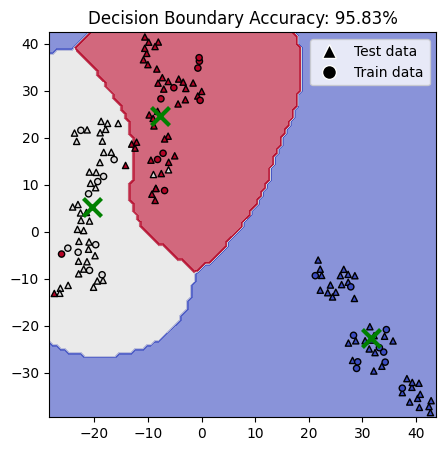

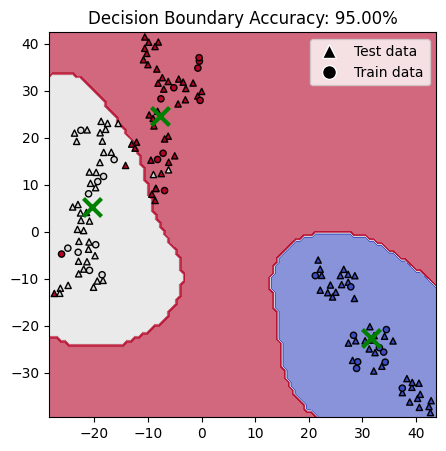

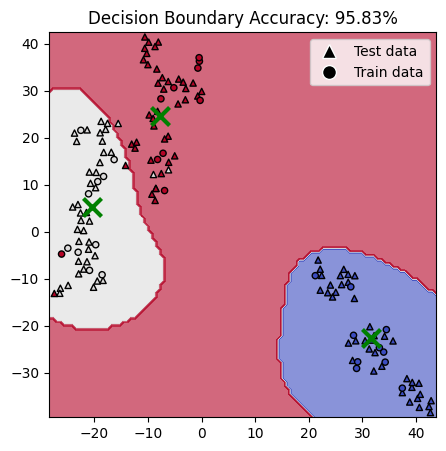

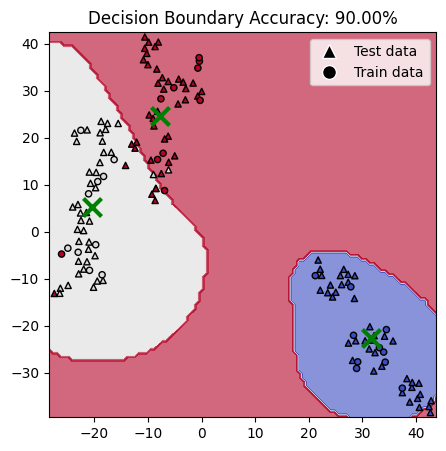

In [7]:
plot_figure(smo_solver, X_tsne, y, nn, X_test, X_train, y_test, y_train, filename= "results\iris_SMO")
plot_figure(sa_OvR, X_tsne, y, nn, X_test, X_train, y_test, y_train, filename= "results\iris_SA")
plot_figure(qa_OvR, X_tsne, y, nn, X_test, X_train, y_test, y_train, filename= "results\iris_QA")
plot_figure(mtqa_OvR, X_tsne, y, nn, X_test, X_train, y_test, y_train, filename= "results\iris_MTQA")

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.2):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 80), np.linspace(y_min, y_max, 80))
    return xx, yy

# Function to plot decision boundaries
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Set up plot figures
fig, sub = plt.subplots(1, 2,figsize=(16, 8))

# Create meshgrid
X0, X1 = X_tsne[:, 0], X_tsne[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Define colormap for plotting
coolwarm = plt.cm.coolwarm
colors = coolwarm(np.linspace(0, 1, nn))
cm = ListedColormap(colors)

# Plot decision boundaries and data points for qSVM
ax = sub[0]
contour = plot_contours(ax, sa_one_vs_rest, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X_tsne[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"SA Decision Boundary Accuracy: {sa_test_accuracy:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Plot decision boundaries and data points for classical SVM
ax = sub[1]
contour = plot_contours(ax, smo_solver, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X_tsne[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"Classic SVM Decision Boundary Accuracy: {smo_test_accuracy:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Colorbar
# cbar = fig.colorbar(contour) #, ax=sub.ravel().tolist(), fraction=0.046, pad=0.04
# cbar.set_ticks(np.arange(0, nn))  # Setting ticks for nn classes
# cbar.set_ticklabels(np.arange(0, nn))  # Setting tick labels

plt.savefig("results\iris_SA_SMO.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.2):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 80), np.linspace(y_min, y_max, 80))
    return xx, yy

# Function to plot decision boundaries
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Set up plot figures
fig, sub = plt.subplots(1, 2,figsize=(16, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.4)

# Create meshgrid
X0, X1 = X_tsne[:, 0], X_tsne[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Define colormap for plotting
coolwarm = plt.cm.coolwarm
colors = coolwarm(np.linspace(0, 1, nn))
cm = ListedColormap(colors)

# Plot decision boundaries and data points for qSVM
ax = sub[0]
contour = plot_contours(ax, qa_OvR, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X_tsne[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"QA Decision Boundary Accuracy: {qa_test_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Plot decision boundaries and data points for classical SVM
ax = sub[1]
contour = plot_contours(ax, mtqa_OvR, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X_tsne[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"MTQA Decision Boundary Accuracy: {mtqa_test_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Colorbar
# cbar = fig.colorbar(contour) #, ax=sub.ravel().tolist(), fraction=0.046, pad=0.04
# cbar.set_ticks(np.arange(0, nn))  # Setting ticks for nn classes
# cbar.set_ticklabels(np.arange(0, nn))  # Setting tick labels

plt.savefig("results\iris_QA_MTQA.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
disp.figure_.suptitle("Classic SMO onfusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.savefig("results\iris_smo_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = sa_one_vs_rest.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("SA Confusion Matrix")

plt.savefig("results\iris_sa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = mtqa_OvR.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("MTQA Confusion Matrix")

plt.savefig("results\iris_mtqa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = qa_OvR.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("QA Confusion Matrix")

plt.savefig("results\digit_0_3_qa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# Initialize the classical SVM classifier
svm_classifier = SVC(kernel='rbf', gamma=gamma)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier
svm_pred = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"Classical SVM Test Accuracy: {svm_accuracy*100:.2f}%")